In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import scipy.stats as stats


In [32]:
years = 15
start = datetime.datetime.now() - datetime.timedelta(days=years*365)
end = datetime.datetime.now()



In [58]:
# List of tickers

tickers = ['SPY',  'BND', 'GLD','QQQ','VTI']


In [59]:
# Download daily adjusted close prices

df_adj_close = pd.DataFrame()

for ticker in tickers:
    df_adj_close[ticker] = yf.download(ticker, start=start, end=end)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [60]:
df_adj_close

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2009-03-09,51.179279,49.320183,90.570000,22.492155,25.481913
2009-03-10,54.230057,49.372181,88.139999,23.881535,27.107605
2009-03-11,54.583214,49.476063,89.220001,24.248537,27.205902
2009-03-12,56.732273,49.586559,91.099998,25.052464,28.325001
2009-03-13,57.175594,49.547550,91.300003,25.113623,28.627453
...,...,...,...,...,...
2024-02-26,505.989990,71.848480,188.199997,436.549988,251.240005
2024-02-27,506.929993,71.738785,188.000000,437.600006,251.940002
2024-02-28,506.260010,71.898331,188.339996,435.269989,251.520004


In [61]:
#  Calc daily log returns and drop na
df_log_returns = np.log(df_adj_close/df_adj_close.shift(1))
df_log_returns.dropna(inplace=True)
df_log_returns


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2009-03-10,0.057901,0.001054,-0.027197,0.059939,0.061845
2009-03-11,0.006491,0.002102,0.012179,0.015251,0.003620
2009-03-12,0.038617,0.002231,0.020853,0.032616,0.040311
2009-03-13,0.007784,-0.000787,0.002193,0.002438,0.010621
2009-03-16,-0.003027,-0.000656,-0.005492,-0.016843,-0.005562
...,...,...,...,...,...
2024-02-26,-0.003669,-0.001803,-0.002229,-0.000527,-0.003020
2024-02-27,0.001856,-0.001528,-0.001063,0.002402,0.002782
2024-02-28,-0.001323,0.002222,0.001807,-0.005339,-0.001668


In [62]:
# Create equaly weighted portfolio

portfolio_valiation = 1000000
portfolio_weights = np.array([1/len(tickers)]*len(tickers))
print(portfolio_weights)



[0.2 0.2 0.2 0.2 0.2]


In [63]:
historical_returns = (df_log_returns*portfolio_weights).sum(axis=1)
print(historical_returns)

Date
2009-03-10    0.030708
2009-03-11    0.007928
2009-03-12    0.026925
2009-03-13    0.004450
2009-03-16   -0.006316
                ...   
2024-02-26   -0.002250
2024-02-27    0.000890
2024-02-28   -0.000860
2024-02-29    0.004625
2024-03-01    0.011270
Length: 3771, dtype: float64


In [64]:
# VAR Parametric Method 
# 5 day period
days = 5
historical_x_day_returns = historical_returns.rolling(window=days).sum()


In [65]:
# Cov matrix
cov_matrix = df_log_returns.cov() * 252


In [66]:
portfolio_std_dev = np.sqrt(portfolio_weights .T @ cov_matrix @ portfolio_weights)

In [67]:
condidence_level = [.9, .95, .99]


In [68]:
from scipy.stats import norm

VARs = []

for cl in condidence_level:
    VARs.append(portfolio_valiation * portfolio_std_dev * norm.ppf(cl) * np.sqrt(days/252))
   

In [69]:
# Print VAR results

print(f' {"Confidence Level":<20} {"Value at Risk":<20}')
print('-' *40)

# Print each confidence level and its corresponding VAR
for cl, var in zip(condidence_level, VARs):
    # print(f' { cl * 100:>6.0f}%: {"":>8}${var:>10, .2f}')
    # print(f'{cl * 100:>6.0f}%: {"":<8} ${var:>10, 2f}')
    print(f'{cl * 100:>6.0f}%: {"":<8} ${var:>10,.2f}')

 Confidence Level     Value at Risk       
----------------------------------------
    90%:          $ 21,358.70
    95%:          $ 27,413.59
    99%:          $ 38,771.56


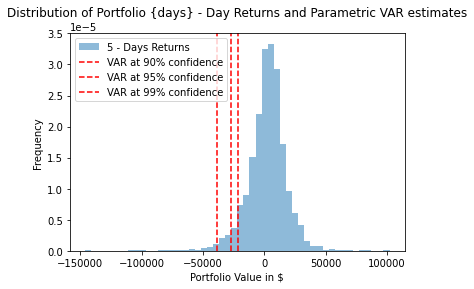

In [73]:
# Graph Represntation
# Convert returns to dollar value for histgram

historical_x_day_returns_dollar = historical_x_day_returns * portfolio_valiation

# Plot the histogram

plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha = 0.5, label = f'{days} - Days Returns')

# Add vertical lines to show VAR at each confidence level

for cl, var in zip(condidence_level, VARs):
    plt.axvline(x=-var, color='r', linestyle='--' , label= 'VAR at {}% confidence'.format(int(cl*100)))

plt.xlabel('Portfolio Value in $')
plt.ylabel('Frequency')
plt.title('Distribution of Portfolio {days} - Day Returns and Parametric VAR estimates')
plt.legend()
plt.show()                